In [1]:
!pip install spacy
!pip install newsapi-python
!python -m spacy download en_core_web_lg
!pip install wordcloud

import en_core_web_lg
from newsapi import NewsApiClient
nlp_eng = en_core_web_lg.load()
newsapi = NewsApiClient (api_key ='4ecc3709f37d48a1adc7b62e1f4f7a3f') #from newsapi.org

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=ee5ba87665dc4d6fad0a27e236c8de57e45307e9bee0451cbe5d659fbb557be8
  Stored in directory: /tmp/pip-ephem-wheel-cache-u30hzhbe/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
articles = newsapi.get_everything(q='coronavirus', language='en', sources='bbc-news',
                              from_param='2021-09-25', to='2021-10-17', 
                              sort_by='relevancy', page=1, page_size = 100)

#We store data inside a pickle file
import pickle
filename = 'articlesCOVID.pckl'
pickle.dump(articles, open(filename, 'wb'))
filename = 'articlesCOVID.pckl'
loaded_model = pickle.load(open(filename, 'rb'))
filepath = '/content/articlesCOVID.pckl'
pickle.dump(loaded_model, open(filepath, 'wb'))

In [19]:
#Now we create a DataFrame in pandas and extract the title, date, description and content
import pandas as pd
dados = []
for i, article in enumerate(articles):
    for x in articles['articles']:
        title = x['title']
        date = x['publishedAt']
        description = x['description']
        content = x['content']
        dados.append({'Title':title, 'Date':date, 'Description':description, 'Content':content})
df = pd.DataFrame(dados)
df = df.dropna()
df.head() #returns the first 5 rows of the dataframe

,Title,Date,Description,Content
0,Dubai opens coronavirus-delayed Expo 2020,2021-09-30T23:08:51Z,Organisers say the world fair will be the larg...,"Image caption, The Expo 2020 opened with a col..."
1,LeBron James gets vaccine after initial scepti...,2021-09-28T22:17:28Z,Basketball great LeBron James says he decided ...,LeBron James' LA Lakers won the NBA title in 2...
2,Coronavirus in DR Congo: How funds went missin...,2021-10-09T08:02:43Z,Dodgy accounting and unofficial bonuses plague...,"Image caption, The study says one hospital cha..."
3,New Zealand raises interest rates for first ti...,2021-10-06T03:38:37Z,The move comes as countries start to remove em...,New Zealand's central bank has raised interest...
4,Singapore to allow quarantine-free travel for ...,2021-10-09T12:57:08Z,The island says it is easing Covid restriction...,"Image caption, Singapore is a major hub for in..."


In [23]:
import string
#Now we clean up the data collected and try to extract keywords of each article. 
#We need to get rid of stop words and punctuation as part of cleaning process
pos_tags = ['VERB', 'NOUN', 'PROPN'] #the tutorial mentions that we only need verbs, nouns and proper nouns
def get_keywords_eng(content):
    page = nlp_eng(content)
    result = []
    punctuation = string.punctuation #a set of all punctuations: !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    for token in page:
        if (token.text in nlp_eng.Defaults.stop_words or token.text in punctuation):
          continue
        if (token.pos_ in pos_tags):
          result.append(token.text)
    return result

#Now we start keyword extraction which involves gathering the 5 most commonly appearing words in the article. We also add an hashtag in front of it
keywords = []
from collections import Counter
for content in df.Content.values:
    keywords.append([('#' + x[0]) for x in Counter(get_keywords_eng(content)).most_common(5)])
df['keywords'] = keywords
df.dropna()
df.head() #We just need to have a glimpse at the first five rows in the dataframe to see if the keywords column got populated correctly




,Title,Date,Description,Content,keywords
0,Dubai opens coronavirus-delayed Expo 2020,2021-09-30T23:08:51Z,Organisers say the world fair will be the larg...,"Image caption, The Expo 2020 opened with a col...","[#Expo, #opened, #Image, #caption, #ceremony]"
1,LeBron James gets vaccine after initial scepti...,2021-09-28T22:17:28Z,Basketball great LeBron James says he decided ...,LeBron James' LA Lakers won the NBA title in 2...,"[#LeBron, #James, #LA, #Lakers, #won]"
2,Coronavirus in DR Congo: How funds went missin...,2021-10-09T08:02:43Z,Dodgy accounting and unofficial bonuses plague...,"Image caption, The study says one hospital cha...","[#m, #Image, #caption, #study, #says]"
3,New Zealand raises interest rates for first ti...,2021-10-06T03:38:37Z,The move comes as countries start to remove em...,New Zealand's central bank has raised interest...,"[#New, #Zealand, #bank, #raised, #interest]"
4,Singapore to allow quarantine-free travel for ...,2021-10-09T12:57:08Z,The island says it is easing Covid restriction...,"Image caption, Singapore is a major hub for in...","[#Singapore, #travel, #Image, #caption, #hub]"


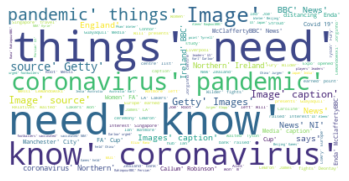

In [24]:
#We plot the keywords in form of a word cloud using matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = str(keywords)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()